# DHIS2 - Tuning HDBSCAN parameters and running clustering

# Inputs
- Absolute path to the directory with .csv files
- Absolute path to the shapefile for your geography

```
!pip install --upgrade pip
!pip install fuzzywuzzy
!conda install -c conda-forge pyshp
!conda install -c conda-forge pyproj
!conda install -c conda-forge proj4
```

In [4]:
import os
import re
import glob
import conda
import hdbscan
import operator
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from config import Config
from collections import Counter
from matplotlib import pyplot as plt
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection

In [5]:
DATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata'
SHAPEFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/geo_files/gadm36_BGD_shp/gadm36_BGD_2'
GEOFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/geo_files/geos_svrs.xlsx'
OUTPUT = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/ces_2014_2016'
GEO_LEVEL = 'districts'
PROJECT = "CES Data 2 Years "

In [6]:
def get_files_list(input_dir):
    input_files = glob.glob(input_dir + "/gdata_unicef_ces*")
    return input_files


def read_data(files_list, common=True):
    data_dict = {}
    for file in files_list:
        data_dict[file] = pd.read_csv(file, encoding='cp850')
        data_dict[file].rename(columns={'Survey.Units"':'geo'}, inplace=True)
        subset = [not bool(re.search(r"Division|Launch District|CC|KCC|RCC|DCC|SCC|CCC|BCC|Urban|Rural|CC Slum| Slum|National", geo)) for geo in data_dict[file]['Survey.Units']]
        print(Counter([not bool(re.search(r"Division|Launch District|CC|KCC|RCC|DCC|SCC|CCC|BCC|Urban|Rural|CC Slum| Slum|National", geo)) for geo in data_dict[file]['Survey.Units']]))
        data_dict[file] = data_dict[file].loc[subset,:]
        print(data_dict[file].shape)
    return data_dict

def subset_vars(ddict):
    cols_list = []
    for key, value in ddict.items():
        print(value.columns)
        print(value.shape[1])
        cols_list.append(list(value.columns))
    cols_list = set(cols_list[0]).intersection(*cols_list)
    for key, value in ddict.items():
        ddict[key] = ddict[key].loc[:,cols_list]
    return ddict

def check_type(ddict):
    check_list = []
    for key, df in ddict.items():
        df_check_list = [var == 'int64' or var == 'float64' for var in df.dtypes]
        check_list.append(all(df_check_list))
    return all(check_list)


def check_geovar(ddict):
    check_list = []
    for key, df in ddict.items():
        if df.columns[0] == 'geo':
            check_list.append(True)
        else:
            check_list.append(False)
    return all(check_list) 


def check_data(ddict):
    return check_type(ddict) and check_geovar(ddict)


def concat_data1(ddict):
    dlist = []
    for key, df in ddict.items():
        print(key[-8:-4])
        df['year'] = key[-8:-4]
        try:
            df['year'] = df['year'].astype(int)
        except ValueError:
            print("No year number in file names")
        dlist.append(df)
    out = pd.concat(dlist, axis=0, sort=True)
    out['Survey.Units'] = out['Survey.Units'].astype(str).str.cat(out['year'].astype(str), sep=" ")
    out = out.drop(['year'], axis=1)
    return out


def concat_data2(ddict):
    dlist = []
    for key, df in ddict.items():
        print(key[-8:-4])
        df['year'] = key[-8:-4]
        try:
            df['year'] = df['year'].astype(int)
        except ValueError:
            print("No year number in file names")
        dlist.append(df)
    out = pd.concat(dlist, axis=0, sort=True)
    if Counter([len(str(var)) for var in out['geo']]) != 1:
        out['geo'] = out['geo'].astype(str).str.pad(width=2, side='left', fillchar='0')
    return out


def create_output_dir(output_dir):
    dir_list = [name for name in os.listdir(os.path.split(output_dir)[0]) if os.path.isdir(name)]
    try:
        os.mkdir(os.path.split(output_dir)[1])
    except FileExistsError:
        print("Directory already present!")


def evaluate_hdbscan(input_df, min_samples, min_cluster_size, 
                     output, cluster_selection_method, 
                     fmin_samples, fmin_cluster_size,
                     prune=False, plot=True):
    samples = list(itertools.product(min_samples, min_cluster_size))
    counter = 0
    models = pd.DataFrame(columns=['min_samples',
                                   'min_cluster_size',
                                   'num_clusters_including_unclustered',
                                   'percent_of_unclustered_geos',
                                   'percent_of_maxclass',],index=range(len(samples)))
    geo = input_df['geo']
    input_df = input_df.drop('geo', axis=1)
    df = input_df.copy(deep=True)
    for iteration in samples:
        model = hdbscan.HDBSCAN(min_samples=int(iteration[0]), 
                                min_cluster_size=int(iteration[1]), 
                                metric='euclidean', 
                                algorithm='best',
                                cluster_selection_method=cluster_selection_method, prediction_data=False).fit(df)
        models.loc[counter,'min_cluster_size'] = iteration[1]
        models.loc[counter, 'min_samples'] = iteration[0]
        models.loc[counter, 'num_clusters_including_unclustered'] = len(Counter(model.labels_))
        tmp_dict = dict(Counter(model.labels_))
        total = sum([v for k,v in tmp_dict.items()])
        tmp_dict = {k:round(v/total*100,2) for k,v in tmp_dict.items()}
        try:
            models.loc[counter, 'percent_of_unclustered_geos'] = tmp_dict.pop(-1)
        except KeyError as error:
            models.loc[counter, 'percent_of_unclustered_geos'] = 0 
        if len(tmp_dict) > 1:
            models.loc[counter, 'percent_of_maxclass'] = tmp_dict[max(tmp_dict.items(), key=operator.itemgetter(1))[0]]
        else:
            models.loc[counter, 'percent_of_maxclass'] = 100
        counter += 1
    if prune:
        out_model = hdbscan.HDBSCAN(min_samples=int(fmin_samples), 
                                min_cluster_size=int(fmin_cluster_size), 
                                metric='euclidean', 
                                algorithm='best',
                                cluster_selection_method=cluster_selection_method, prediction_data=False).fit(df)

    else:
        out_model = None
    models.to_csv(os.path.split(output)[1] + "/models_overview.csv", index=False, index_label=False)
    if plot:
        plt.rcParams['figure.figsize'] = [20,10]
        plt.plot(models['num_clusters_including_unclustered'], label='Number of clusters including unclustered')
        plt.savefig(os.path.split(output)[1] + "/finetune_parameteres.jpeg")
        plt.legend()
        plt.show()
    del(input_df, df)
    return models, out_model


def cluster_data(input_df, f_min_samples, f_min_cluster_size, cluster_selection_method):
    df = input_df.copy(deep=True)
    cluster_data = df.drop(['geo', 'year'], axis=1)
    print(cluster_data.columns)
    model = hdbscan.HDBSCAN(min_samples=int(f_min_samples), 
                            min_cluster_size=int(f_min_cluster_size), 
                            metric='euclidean', 
                            algorithm='best', 
                           cluster_selection_method=cluster_selection_method).fit(cluster_data)
    print(Counter(model.labels_))
    df['class'] = model.labels_
    return df
    

def create_mapobject(shp_path, shp_name):
    m = Basemap(llcrnrlon=87.8, llcrnrlat=20.3, urcrnrlon=94, urcrnrlat=27, resolution='c')
    m.readshapefile(shapefile=shp_path, name=shp_name, drawbounds=True)
    return m


def colors2clusters(df_input, cluster_var):
    df = df_input.copy(deep=True)
    df['colors'] = df[cluster_var].astype('category')
    labs = list(df['colors'].cat.categories)
    clusters = list(df[cluster_var].unique())
    colors = sns.color_palette('Paired', len(clusters)).as_hex()
    df['colors'] = df['colors'].cat.rename_categories(colors)
    cols = list(df['colors'].cat.categories)
    return df, list(zip(labs,cols))


def data2map(mapobj, mapobj_key, data, data_key):
    for district in mapobj.districts_info:
        district['CLUSTER'] = data.loc[data[data_key] == district[mapobj_key],'colors'][0]
    return mapobj


def plot_geos(mapobj, mapobj_key, labels_colors, title, output):
    geo_names = []
    for shape_dict in mapobj.districts_info:
        geo_names.append(int(shape_dict[mapobj_key]))
    ax = plt.gca()
    for info, shape in zip(mapobj.districts_info, mapobj.districts):
        poly = Polygon(shape, facecolor=info['CLUSTER'], edgecolor=info['CLUSTER'])
        ax.add_patch(poly)
    legend_elements = [Line2D([0], [0], marker="s", color=col, label=label, markerfacecolor=col, markersize=25)
                   for label, col in labels_colors] 
    plt.legend(handles=legend_elements, loc='upper right',borderpad=2)
    plt.title(title)
    plt.savefig(os.path.join(output, title + ".jpeg"))
    plt.show()
    plt.close()


def plot_clusters(input_df, shapefile, geo_level, project, output):
    df = input_df.copy(deep=True)
    plt.rcParams['figure.figsize'] = [10,10]
    for year in sorted(list(df['year'].unique())):
        m = create_mapobject(shp_path=shapefile,shp_name=geo_level)
        tmp = df[df['year'] == year]
        print(tmp['year'].unique())
        m = data2map(mapobj=m, mapobj_key='CC_2', data=tmp, data_key='geo')
        plot_geos(mapobj=m, mapobj_key='CC_2',labels_colors=labs_cols, title=project + str(year), output=output)
    

def get_statistics(input_df, output, title):
    df = input_df.copy(deep=True)
    out = {}
    for year in df['year'].unique():
        tmp = df[df['year'] == year]
        variables = list(tmp.drop(['year', 'geo', 'class', 'colors'], axis=1).columns)
        tmp = tmp.drop(['year','geo'], axis=1)
        tmpgroupby = tmp.groupby('class')
        output_year = [] 
        for variable in variables:
            print(variable)
            tmp = tmpgroupby[variable].agg([np.mean, np.std, np.max, np.min]).transpose()
            tmp['var'] = variable
            output_year.append(tmp)
        out[year] = pd.concat(output_year, axis=0)
        out[year].to_csv(os.path.join(output, title+"_" +str(year) + ".csv"),index=False, index_label=False)
    return out


def update_geo1(input_df, input_geo, geo_var):
    df = input_df.copy(deep=True)
    geodata = pd.read_excel(input_geo)
    geodata['dv'] = geodata['dv'].astype(str)
    geodata['zl'] = geodata['zl'].astype(str)
    geodata['dv'] = geodata['dv'].str.pad(width=2,side='left',fillchar='0')
    geodata['zl'] = geodata['zl'].str.pad(width=2,side='left',fillchar='0')
    geodata['geo_full'] = geodata['dv'].str.cat(geodata['zl'], sep='')
    geodata = geodata[['geo_full','dv','Div_Name','zl','Zila_Name2']]
    geodata = geodata.drop_duplicates()
    display(geodata.head())
    display(df.head())
    df = df.merge(right=geodata, left_on='geo', right_on=geo_var)
    print(df.shape)
    df = df.drop(['dv', 'Div_Name', 'zl', 'Zila_Name2', 'geo'], axis=1)
    df.rename(columns={'geo_full':'geo'}, inplace=True)
    return df


def update_geo2(input_df, input_geo, geo_var):
    df = input_df.copy(deep=True)
    geodata = pd.read_excel(input_geo)
    geodata['dv'] = geodata['dv'].astype(str)
    geodata['zl'] = geodata['zl'].astype(str)
    geodata['dv'] = geodata['dv'].str.pad(width=2,side='left',fillchar='0')
    geodata['zl'] = geodata['zl'].str.pad(width=2,side='left',fillchar='0')
    geodata['geo_full'] = geodata['dv'].str.cat(geodata['zl'], sep='')
    geodata = geodata[['geo_full','dv','Div_Name','zl','Zila_Name2']]
    geodata = geodata.drop_duplicates()
    df = df.merge(right=geodata, left_on='geo', right_on=geo_var)
    df.rename(columns={'geo_full':'geo'}, inplace=True)
    return df

def imput_missing(input_df):
    df = input_df.copy(deep=True)
    for var in df.columns:
        if df[var].dtype != 'object':
            if df[var].isna().value_counts()[0]/df[var].shape[0] != 1.:
                tmp = df[var].fillna(np.mean(df[var]))
                df = df.drop(var,axis=1)
                df[var] = tmp
    return df


def output_class(input_df):
    df = input_df.copy(deep=True)
    out = list()
    for geo_var in df['geo'].unique():
        tmp = df[df['geo'] == geo_var]
        tmp = tmp[['geo','year', 'class']]
        tmp = tmp.pivot(index='geo', columns='year', values='class')
        tmp.reset_index(inplace=True)
        out.append(tmp)
    output = pd.concat(out, axis=0)
    output = output.reset_index(drop=True)
    return output

def output_table(input_df, out, name):
    df = input_df.copy(deep=True)
    remove = ['geo','year','colors']
    columns = df.columns
    variables = list(set(columns).difference(set(remove)))
    print(variables)
    out_min = df[variables].groupby('class').min().round(4)
    out_max = df[variables].groupby('class').max().round(4)
    out_mean = df[variables].groupby('class').mean().round(1)
    t = out_min.astype(str).add(' - ').add(out_mean.astype(str))
    t = t.astype(str).add(' - ').add(out_max.astype(str))
    t.to_csv(out+"/"+name+".csv", index_label=False)
    return t


## PART 1: Fine-tuning the clustering model
### STEP 1: Get files list

In [7]:
dfiles = get_files_list(input_dir=DATA)
dfiles = ['/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2016.csv',
          '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2014.csv',]


### STEP 2: Read data

In [8]:
ddata = read_data(files_list=dfiles)

Counter({True: 64, False: 24})
(64, 52)
Counter({True: 64, False: 23})
(64, 50)


In [9]:
ddata = subset_vars(ddict=ddata)

Index(['DistrictCode', 'DistrictName', 'DivisionCode', 'DivisionName',
       'FuzzRatio', 'Geo', 'Survey.Units', 'BCG_Children23M',
       'OPV1_Children23M', 'PENTA1_Children23M', 'OPV2_Children23M',
       'PENTA2_Children23M', 'OPV3_Children23M', 'PENTA3_Children23M',
       'Measles_Children23M', 'Fully_Children23M', 'BCG_Children12M',
       'OPV1_Children12M', 'PENTA1_Children12M', 'OPV2_Children12M',
       'PENTA2_Children12M', 'OPV3_Children12M', 'PENTA3_Children12M',
       'Measles_Children12M', 'Fully_Children12M',
       'DropoutPENTA1-PENTA3_Male23M', 'DropoutPENTA1-PENTA3_Female23M',
       'DropoutPENTA1-PENTA3_Children23M', 'DropoutPENTA1-Measles_Male23M',
       'DropoutPENTA1-Measles_Female23M', 'DropoutPENTA1-Measles_Children23M',
       'InvalidPENTA1_Infant12M', 'InvalidPENTA2_Infant12M',
       'InvalidPENTA3_Infant12M', 'InvalidMeasles_Infant12M',
       'Measles2ndDoseCrude', 'Measles2ndDose_Children18M',
       'Measles2ndDose_Children23M', 'TT1_Mother0-11MCh

### STEP 3: Check data 

In [10]:
dcheck = check_data(ddict=ddata)
dcheck

False

### STEP 4: Concat data 

In [11]:
ddf = concat_data1(ddict=ddata)

2016
2014


In [12]:
ddf.head()

,BCG_Children12M,BCG_Children23M,DistrictCode,DistrictName,DivisionCode,DivisionName,DropoutPENTA1-Measles_Children23M,DropoutPENTA1-PENTA3_Children23M,Fully_Children12M,Fully_Children23M,...,TT3_Mother0-11MChildren,TT3_Woman18-49Y,TT4_Mother0-11MChildren,TT4_Woman18-49Y,TT5_Mother0-11MChildren,TT5_Woman18-49Y,TetanusAtBirth_Mother0-11MChildren,VitACoverage_Children12-59M,VitACoverage_Infants6-11M,Year
0,98.2,98.2,1,Bagerhat,40,Khulna,3.4,1.9,86.8,88.3,...,85.3,74.9,61.9,50.2,36.5,29.7,89.1,82.0,75.7,2016
1,99.0,99.0,3,Bandarban,20,Chittagong,4.7,1.5,80.9,83.9,...,86.1,85.0,79.6,74.6,65.3,61.2,89.2,84.1,78.4,2016
2,99.7,99.7,4,Barguna,10,Barisal,2.1,0.3,87.6,91.1,...,88.4,74.5,64.4,49.2,36.3,30.1,80.2,96.8,92.6,2016
3,99.7,99.7,6,Barisal,10,Barisal,0.0,NaN,91.0,94.6,...,96.7,88.9,79.3,75.6,60.0,59.8,97.6,100.0,100.0,2016
6,99.8,99.8,9,Bhola,10,Barisal,0.0,0.0,91.3,91.9,...,94.1,94.8,79.0,80.8,56.1,65.0,99.6,98.4,97.7,2016


### STEP 5: Create output dir

In [13]:
create_output_dir(output_dir=OUTPUT)

### STEP 6: Data and geo clean up child health data

In [14]:
ddf['DistrictCode'] = ddf['DistrictCode'].astype(str)
ddf['DivisionCode'] = ddf['DivisionCode'].astype(str)
ddf['DistrictCode'] = ddf['DistrictCode'].str.pad(width=2, side='left', fillchar='0')
ddf['DivisionCode'] = ddf['DivisionCode'].str.pad(width=2, side='left', fillchar='0')
print(Counter([len(string) for string in ddf['DistrictCode']]))
print(Counter([len(string) for string in ddf['DivisionCode']]))
ddf['geo'] = ddf['DivisionCode'].str.cat(ddf['DistrictCode'])
display(ddf.head())
print(ddf.columns)

Counter({2: 128})
Counter({2: 128})


,BCG_Children12M,BCG_Children23M,DistrictCode,DistrictName,DivisionCode,DivisionName,DropoutPENTA1-Measles_Children23M,DropoutPENTA1-PENTA3_Children23M,Fully_Children12M,Fully_Children23M,...,TT3_Woman18-49Y,TT4_Mother0-11MChildren,TT4_Woman18-49Y,TT5_Mother0-11MChildren,TT5_Woman18-49Y,TetanusAtBirth_Mother0-11MChildren,VitACoverage_Children12-59M,VitACoverage_Infants6-11M,Year,geo
0,98.2,98.2,01,Bagerhat,40,Khulna,3.4,1.9,86.8,88.3,...,74.9,61.9,50.2,36.5,29.7,89.1,82.0,75.7,2016,4001
1,99.0,99.0,03,Bandarban,20,Chittagong,4.7,1.5,80.9,83.9,...,85.0,79.6,74.6,65.3,61.2,89.2,84.1,78.4,2016,2003
2,99.7,99.7,04,Barguna,10,Barisal,2.1,0.3,87.6,91.1,...,74.5,64.4,49.2,36.3,30.1,80.2,96.8,92.6,2016,1004
3,99.7,99.7,06,Barisal,10,Barisal,0.0,NaN,91.0,94.6,...,88.9,79.3,75.6,60.0,59.8,97.6,100.0,100.0,2016,1006
6,99.8,99.8,09,Bhola,10,Barisal,0.0,0.0,91.3,91.9,...,94.8,79.0,80.8,56.1,65.0,99.6,98.4,97.7,2016,1009


Index(['BCG_Children12M', 'BCG_Children23M', 'DistrictCode', 'DistrictName',
       'DivisionCode', 'DivisionName', 'DropoutPENTA1-Measles_Children23M',
       'DropoutPENTA1-PENTA3_Children23M', 'Fully_Children12M',
       'Fully_Children23M', 'FuzzRatio', 'Geo', 'InvalidMeasles_Infant12M',
       'InvalidPENTA1_Infant12M', 'InvalidPENTA2_Infant12M',
       'InvalidPENTA3_Infant12M', 'Measles_Children12M', 'Measles_Children23M',
       'OPV1_Children12M', 'OPV1_Children23M', 'OPV2_Children12M',
       'OPV2_Children23M', 'OPV3_Children12M', 'OPV3_Children23M',
       'PENTA1_Children12M', 'PENTA1_Children23M', 'PENTA2_Children12M',
       'PENTA2_Children23M', 'PENTA3_Children12M', 'PENTA3_Children23M',
       'Survey.Units', 'TT1_Mother0-11MChildren', 'TT1_Woman18-49Y',
       'TT2_Mother0-11MChildren', 'TT2_Woman18-49Y', 'TT3_Mother0-11MChildren',
       'TT3_Woman18-49Y', 'TT4_Mother0-11MChildren', 'TT4_Woman18-49Y',
       'TT5_Mother0-11MChildren', 'TT5_Woman18-49Y',
       'Teta

In [15]:
immunisation_drop = ['DistrictCode', 'DistrictName', 'DivisionCode', 'DivisionName',
                     'FuzzRatio', 'Geo', 'Year', 'Survey.Units', ]
immunisation_data = ddf.drop(immunisation_drop, axis=1)
immunisation_data.head()


,BCG_Children12M,BCG_Children23M,DropoutPENTA1-Measles_Children23M,DropoutPENTA1-PENTA3_Children23M,Fully_Children12M,Fully_Children23M,InvalidMeasles_Infant12M,InvalidPENTA1_Infant12M,InvalidPENTA2_Infant12M,InvalidPENTA3_Infant12M,...,TT3_Mother0-11MChildren,TT3_Woman18-49Y,TT4_Mother0-11MChildren,TT4_Woman18-49Y,TT5_Mother0-11MChildren,TT5_Woman18-49Y,TetanusAtBirth_Mother0-11MChildren,VitACoverage_Children12-59M,VitACoverage_Infants6-11M,geo
0,98.2,98.2,3.4,1.9,86.8,88.3,2.6,1.4,3.1,4.7,...,85.3,74.9,61.9,50.2,36.5,29.7,89.1,82.0,75.7,4001
1,99.0,99.0,4.7,1.5,80.9,83.9,4.8,4.3,7.2,8.5,...,86.1,85.0,79.6,74.6,65.3,61.2,89.2,84.1,78.4,2003
2,99.7,99.7,2.1,0.3,87.6,91.1,2.3,2.2,2.9,3.9,...,88.4,74.5,64.4,49.2,36.3,30.1,80.2,96.8,92.6,1004
3,99.7,99.7,0.0,NaN,91.0,94.6,2.8,1.9,2.3,3.3,...,96.7,88.9,79.3,75.6,60.0,59.8,97.6,100.0,100.0,1006
6,99.8,99.8,0.0,0.0,91.3,91.9,3.3,2.5,3.6,5.2,...,94.1,94.8,79.0,80.8,56.1,65.0,99.6,98.4,97.7,1009


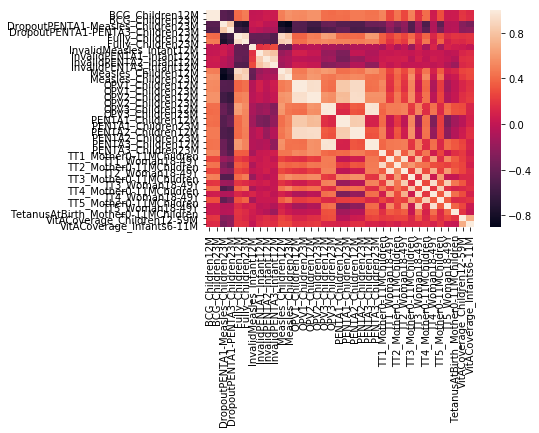

In [16]:
corr = immunisation_data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [17]:
corr

,BCG_Children12M,BCG_Children23M,DropoutPENTA1-Measles_Children23M,DropoutPENTA1-PENTA3_Children23M,Fully_Children12M,Fully_Children23M,InvalidMeasles_Infant12M,InvalidPENTA1_Infant12M,InvalidPENTA2_Infant12M,InvalidPENTA3_Infant12M,...,TT2_Woman18-49Y,TT3_Mother0-11MChildren,TT3_Woman18-49Y,TT4_Mother0-11MChildren,TT4_Woman18-49Y,TT5_Mother0-11MChildren,TT5_Woman18-49Y,TetanusAtBirth_Mother0-11MChildren,VitACoverage_Children12-59M,VitACoverage_Infants6-11M
BCG_Children12M,1.000000,0.995066,-0.464330,-0.505711,0.406652,0.473384,0.009220,0.017570,0.055552,0.043179,...,0.267003,0.496213,0.194373,0.419212,0.061645,0.295048,0.046356,0.049497,0.195000,0.137878
BCG_Children23M,0.995066,1.000000,-0.460557,-0.495835,0.403809,0.470986,0.018075,0.022878,0.056281,0.046610,...,0.267914,0.488872,0.200015,0.413922,0.066356,0.296121,0.046138,0.053723,0.199580,0.150973
DropoutPENTA1-Measles_Children23M,-0.464330,-0.460557,1.000000,0.827121,-0.704216,-0.760812,0.040481,0.058077,-0.016136,-0.040415,...,-0.206082,-0.485261,-0.150319,-0.509622,-0.077221,-0.430718,-0.050291,-0.041169,-0.252429,-0.320265
DropoutPENTA1-PENTA3_Children23M,-0.505711,-0.495835,0.827121,1.000000,-0.584252,-0.635781,-0.009721,-0.043937,-0.103750,-0.101482,...,-0.244553,-0.484960,-0.171330,-0.440717,-0.070350,-0.321448,-0.052237,-0.036271,-0.231108,-0.213329
Fully_Children12M,0.406652,0.403809,-0.704216,-0.584252,1.000000,0.931909,-0.410948,-0.415941,-0.402812,-0.490840,...,0.259425,0.399029,0.195366,0.382779,0.126200,0.305948,0.147173,0.194712,0.179680,0.189783
Fully_Children23M,0.473384,0.470986,-0.760812,-0.635781,0.931909,1.000000,-0.439764,-0.412510,-0.438136,-0.497226,...,0.215008,0.473966,0.147570,0.452464,0.071260,0.378357,0.084290,0.145318,0.135927,0.178151
InvalidMeasles_Infant12M,0.009220,0.018075,0.040481,-0.009721,-0.410948,-0.439764,1.000000,0.179958,0.211938,0.280558,...,0.008086,-0.178135,0.092757,-0.109214,0.118442,-0.115521,0.102528,0.064451,0.050504,0.006787
InvalidPENTA1_Infant12M,0.017570,0.022878,0.058077,-0.043937,-0.415941,-0.412510,0.179958,1.000000,0.849728,0.793469,...,0.031120,0.012218,0.051941,0.006793,0.040959,0.038264,-0.020148,0.002268,0.118360,0.152205
InvalidPENTA2_Infant12M,0.055552,0.056281,-0.016136,-0.103750,-0.402812,-0.438136,0.211938,0.849728,1.000000,0.891313,...,0.078747,-0.039780,0.083669,-0.010668,0.068284,0.037739,0.003738,-0.054937,0.164494,0.177936
InvalidPENTA3_Infant12M,0.043179,0.046610,-0.040415,-0.101482,-0.490840,-0.497226,0.280558,0.793469,0.891313,1.000000,...,0.003158,0.016833,0.011401,0.024224,-0.010235,0.031804,-0.069517,-0.161810,0.135140,0.160987


In [18]:
for var in immunisation_data.columns:
    print(immunisation_data[var].isna().value_counts()/immunisation_data.shape[0])
immunisation_data = imput_missing(input_df=immunisation_data)  
for var in immunisation_data.columns:
    print(immunisation_data[var].isna().value_counts()/immunisation_data.shape[0])

False    1.0
Name: BCG_Children12M, dtype: float64
False    1.0
Name: BCG_Children23M, dtype: float64
False    0.984375
True     0.015625
Name: DropoutPENTA1-Measles_Children23M, dtype: float64
False    0.984375
True     0.015625
Name: DropoutPENTA1-PENTA3_Children23M, dtype: float64
False    1.0
Name: Fully_Children12M, dtype: float64
False    1.0
Name: Fully_Children23M, dtype: float64
False    1.0
Name: InvalidMeasles_Infant12M, dtype: float64
False    1.0
Name: InvalidPENTA1_Infant12M, dtype: float64
False    1.0
Name: InvalidPENTA2_Infant12M, dtype: float64
False    1.0
Name: InvalidPENTA3_Infant12M, dtype: float64
False    1.0
Name: Measles_Children12M, dtype: float64
False    1.0
Name: Measles_Children23M, dtype: float64
False    1.0
Name: OPV1_Children12M, dtype: float64
False    1.0
Name: OPV1_Children23M, dtype: float64
False    1.0
Name: OPV2_Children12M, dtype: float64
False    1.0
Name: OPV2_Children23M, dtype: float64
False    1.0
Name: OPV3_Children12M, dtype: float64
Fa

### STEP 6: Fine tune and analyze the data and obtain the output of paramaters

In [19]:
immunisation_data.columns

Index(['BCG_Children12M', 'BCG_Children23M', 'Fully_Children12M',
       'Fully_Children23M', 'InvalidMeasles_Infant12M',
       'InvalidPENTA1_Infant12M', 'InvalidPENTA2_Infant12M',
       'InvalidPENTA3_Infant12M', 'Measles_Children12M', 'Measles_Children23M',
       'OPV1_Children12M', 'OPV1_Children23M', 'OPV2_Children12M',
       'OPV2_Children23M', 'OPV3_Children12M', 'OPV3_Children23M',
       'PENTA1_Children12M', 'PENTA1_Children23M', 'PENTA2_Children12M',
       'PENTA2_Children23M', 'PENTA3_Children12M', 'PENTA3_Children23M',
       'TT1_Mother0-11MChildren', 'TT1_Woman18-49Y', 'TT2_Mother0-11MChildren',
       'TT2_Woman18-49Y', 'TT3_Mother0-11MChildren', 'TT3_Woman18-49Y',
       'TT4_Mother0-11MChildren', 'TT4_Woman18-49Y', 'TT5_Mother0-11MChildren',
       'TT5_Woman18-49Y', 'TetanusAtBirth_Mother0-11MChildren',
       'VitACoverage_Children12-59M', 'VitACoverage_Infants6-11M', 'geo',
       'DropoutPENTA1-Measles_Children23M',
       'DropoutPENTA1-PENTA3_Children23M'],

In [20]:
immunisation_data.head()

,BCG_Children12M,BCG_Children23M,Fully_Children12M,Fully_Children23M,InvalidMeasles_Infant12M,InvalidPENTA1_Infant12M,InvalidPENTA2_Infant12M,InvalidPENTA3_Infant12M,Measles_Children12M,Measles_Children23M,...,TT4_Mother0-11MChildren,TT4_Woman18-49Y,TT5_Mother0-11MChildren,TT5_Woman18-49Y,TetanusAtBirth_Mother0-11MChildren,VitACoverage_Children12-59M,VitACoverage_Infants6-11M,geo,DropoutPENTA1-Measles_Children23M,DropoutPENTA1-PENTA3_Children23M
0,98.2,98.2,86.8,88.3,2.6,1.4,3.1,4.7,90.3,92.2,...,61.9,50.2,36.5,29.7,89.1,82.0,75.7,4001,3.4,1.900000
1,99.0,99.0,80.9,83.9,4.8,4.3,7.2,8.5,86.3,89.8,...,79.6,74.6,65.3,61.2,89.2,84.1,78.4,2003,4.7,1.500000
2,99.7,99.7,87.6,91.1,2.3,2.2,2.9,3.9,91.0,94.9,...,64.4,49.2,36.3,30.1,80.2,96.8,92.6,1004,2.1,0.300000
3,99.7,99.7,91.0,94.6,2.8,1.9,2.3,3.3,93.1,97.1,...,79.3,75.6,60.0,59.8,97.6,100.0,100.0,1006,0.0,1.604762
6,99.8,99.8,91.3,91.9,3.3,2.5,3.6,5.2,95.4,96.6,...,79.0,80.8,56.1,65.0,99.6,98.4,97.7,1009,0.0,0.000000


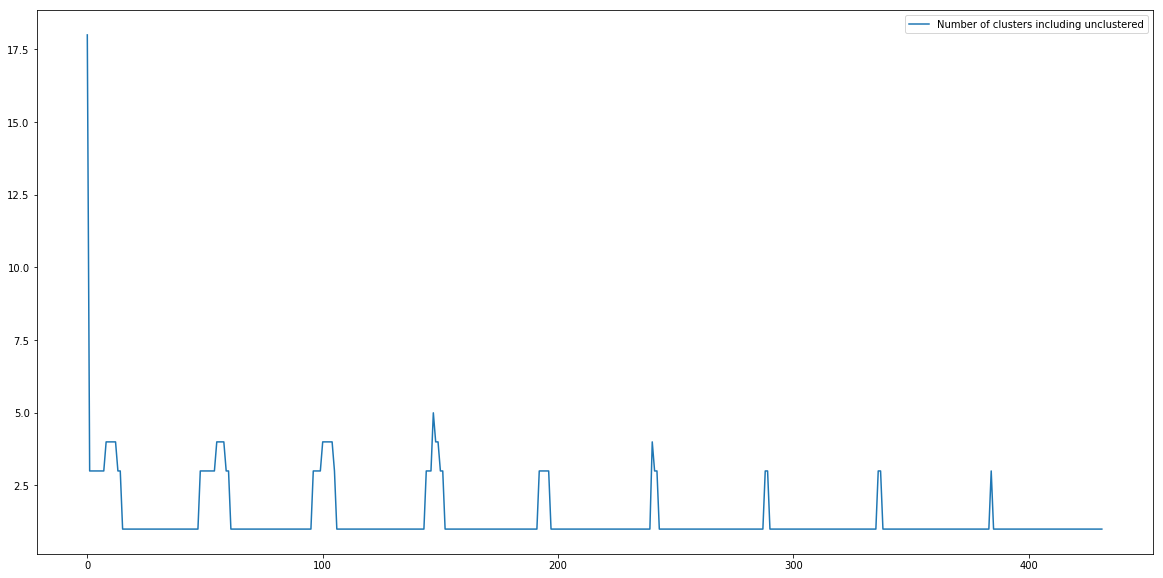

In [21]:
tmp, out = evaluate_hdbscan(input_df=immunisation_data, 
                       min_samples=Config.tune_min_sample, 
                       min_cluster_size=Config.tune_min_cluster,
                       output=OUTPUT, cluster_selection_method ='eom',
                       fmin_samples=3, fmin_cluster_size=12,
                       prune=True)

In [22]:
tmp = tmp[tmp['num_clusters_including_unclustered'] < 10]
tmp = tmp.loc[tmp['num_clusters_including_unclustered'] > 3].sort_values(by='percent_of_unclustered_geos', ascending=True)
tmp.sort_values(by='percent_of_unclustered_geos', ascending=True).head(50)

,min_samples,min_cluster_size,num_clusters_including_unclustered,percent_of_unclustered_geos,percent_of_maxclass
8,1,10,4,53.12,23.44
9,1,11,4,53.12,23.44
10,1,12,4,53.12,23.44
11,1,13,4,53.12,23.44
12,1,14,4,53.12,23.44
55,2,9,4,60.94,18.75
56,2,10,4,60.94,18.75
57,2,11,4,60.94,18.75
58,2,12,4,60.94,18.75
240,6,2,4,65.62,29.69


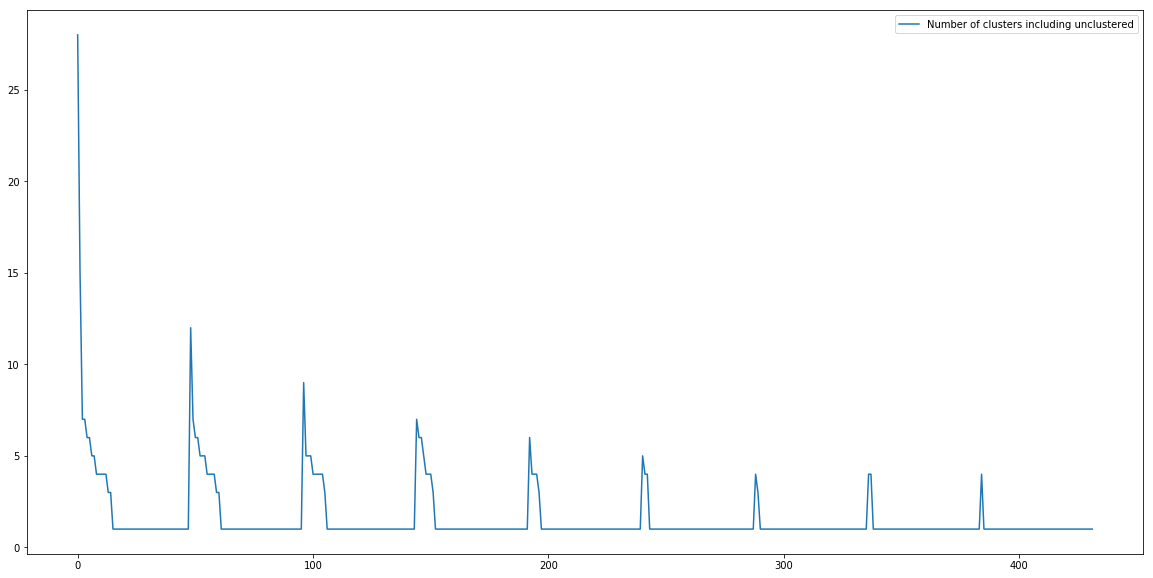

In [23]:
tmp, out = evaluate_hdbscan(input_df=immunisation_data, 
                       min_samples=Config.tune_min_sample, 
                       min_cluster_size=Config.tune_min_cluster,
                       output=OUTPUT, cluster_selection_method ='leaf',
                       fmin_samples=3, fmin_cluster_size=12,
                       prune=True)

In [24]:
tmp = tmp[tmp['num_clusters_including_unclustered'] < 20]
tmp = tmp.loc[tmp['num_clusters_including_unclustered'] > 3].sort_values(by='percent_of_unclustered_geos', ascending=True)
tmp.sort_values(by='percent_of_unclustered_geos', ascending=True).head(50)

,min_samples,min_cluster_size,num_clusters_including_unclustered,percent_of_unclustered_geos,percent_of_maxclass
4,1,6,6,40.62,23.44
5,1,7,6,40.62,23.44
2,1,4,7,42.97,23.44
3,1,5,7,42.97,23.44
6,1,8,5,46.09,23.44
7,1,9,5,46.09,23.44
51,2,5,6,50.78,18.75
50,2,4,6,50.78,18.75
1,1,3,15,51.56,7.81
11,1,13,4,53.12,23.44


# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------

## PART 2: Running the clustering
### STEP 1: Get files list

In [25]:
dfiles = get_files_list(input_dir=DATA)
print(dfiles)

['/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2016.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2015.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2014.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2010.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2011.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2013.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2006.csv']


### STEP 2: Read data

In [26]:
dfiles = ['/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2016.csv',
          '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2014.csv',]

ddata = read_data(files_list=dfiles)
ddata = subset_vars(ddict=ddata)

Counter({True: 64, False: 24})
(64, 52)
Counter({True: 64, False: 23})
(64, 50)
Index(['DistrictCode', 'DistrictName', 'DivisionCode', 'DivisionName',
       'FuzzRatio', 'Geo', 'Survey.Units', 'BCG_Children23M',
       'OPV1_Children23M', 'PENTA1_Children23M', 'OPV2_Children23M',
       'PENTA2_Children23M', 'OPV3_Children23M', 'PENTA3_Children23M',
       'Measles_Children23M', 'Fully_Children23M', 'BCG_Children12M',
       'OPV1_Children12M', 'PENTA1_Children12M', 'OPV2_Children12M',
       'PENTA2_Children12M', 'OPV3_Children12M', 'PENTA3_Children12M',
       'Measles_Children12M', 'Fully_Children12M',
       'DropoutPENTA1-PENTA3_Male23M', 'DropoutPENTA1-PENTA3_Female23M',
       'DropoutPENTA1-PENTA3_Children23M', 'DropoutPENTA1-Measles_Male23M',
       'DropoutPENTA1-Measles_Female23M', 'DropoutPENTA1-Measles_Children23M',
       'InvalidPENTA1_Infant12M', 'InvalidPENTA2_Infant12M',
       'InvalidPENTA3_Infant12M', 'InvalidMeasles_Infant12M',
       'Measles2ndDoseCrude', 'Meas

### STEP3: Check data 

In [27]:
dcheck = check_data(ddict=ddata)
dcheck

False

### STEP4: Concat data 

In [28]:
ddf = concat_data1(ddict=ddata)
ddf['DistrictCode'] = ddf['DistrictCode'].astype(str)
ddf['DivisionCode'] = ddf['DivisionCode'].astype(str)
ddf['DistrictCode'] = ddf['DistrictCode'].str.pad(width=2, side='left', fillchar='0')
ddf['DivisionCode'] = ddf['DivisionCode'].str.pad(width=2, side='left', fillchar='0')
print(Counter([len(string) for string in ddf['DistrictCode']]))
print(Counter([len(string) for string in ddf['DivisionCode']]))
ddf['geo'] = ddf['DivisionCode'].str.cat(ddf['DistrictCode'])
display(ddf.head())
print(ddf.columns)
immunisation_drop = ['DistrictCode', 'DistrictName', 'DivisionCode', 'DivisionName',
                     'FuzzRatio', 'Geo', 'Survey.Units', ]
immunisation_data = ddf.drop(immunisation_drop, axis=1)
immunisation_data.head()

2016
2014
Counter({2: 128})
Counter({2: 128})


,BCG_Children12M,BCG_Children23M,DistrictCode,DistrictName,DivisionCode,DivisionName,DropoutPENTA1-Measles_Children23M,DropoutPENTA1-PENTA3_Children23M,Fully_Children12M,Fully_Children23M,...,TT3_Woman18-49Y,TT4_Mother0-11MChildren,TT4_Woman18-49Y,TT5_Mother0-11MChildren,TT5_Woman18-49Y,TetanusAtBirth_Mother0-11MChildren,VitACoverage_Children12-59M,VitACoverage_Infants6-11M,Year,geo
0,98.2,98.2,01,Bagerhat,40,Khulna,3.4,1.9,86.8,88.3,...,74.9,61.9,50.2,36.5,29.7,89.1,82.0,75.7,2016,4001
1,99.0,99.0,03,Bandarban,20,Chittagong,4.7,1.5,80.9,83.9,...,85.0,79.6,74.6,65.3,61.2,89.2,84.1,78.4,2016,2003
2,99.7,99.7,04,Barguna,10,Barisal,2.1,0.3,87.6,91.1,...,74.5,64.4,49.2,36.3,30.1,80.2,96.8,92.6,2016,1004
3,99.7,99.7,06,Barisal,10,Barisal,0.0,NaN,91.0,94.6,...,88.9,79.3,75.6,60.0,59.8,97.6,100.0,100.0,2016,1006
6,99.8,99.8,09,Bhola,10,Barisal,0.0,0.0,91.3,91.9,...,94.8,79.0,80.8,56.1,65.0,99.6,98.4,97.7,2016,1009


Index(['BCG_Children12M', 'BCG_Children23M', 'DistrictCode', 'DistrictName',
       'DivisionCode', 'DivisionName', 'DropoutPENTA1-Measles_Children23M',
       'DropoutPENTA1-PENTA3_Children23M', 'Fully_Children12M',
       'Fully_Children23M', 'FuzzRatio', 'Geo', 'InvalidMeasles_Infant12M',
       'InvalidPENTA1_Infant12M', 'InvalidPENTA2_Infant12M',
       'InvalidPENTA3_Infant12M', 'Measles_Children12M', 'Measles_Children23M',
       'OPV1_Children12M', 'OPV1_Children23M', 'OPV2_Children12M',
       'OPV2_Children23M', 'OPV3_Children12M', 'OPV3_Children23M',
       'PENTA1_Children12M', 'PENTA1_Children23M', 'PENTA2_Children12M',
       'PENTA2_Children23M', 'PENTA3_Children12M', 'PENTA3_Children23M',
       'Survey.Units', 'TT1_Mother0-11MChildren', 'TT1_Woman18-49Y',
       'TT2_Mother0-11MChildren', 'TT2_Woman18-49Y', 'TT3_Mother0-11MChildren',
       'TT3_Woman18-49Y', 'TT4_Mother0-11MChildren', 'TT4_Woman18-49Y',
       'TT5_Mother0-11MChildren', 'TT5_Woman18-49Y',
       'Teta

,BCG_Children12M,BCG_Children23M,DropoutPENTA1-Measles_Children23M,DropoutPENTA1-PENTA3_Children23M,Fully_Children12M,Fully_Children23M,InvalidMeasles_Infant12M,InvalidPENTA1_Infant12M,InvalidPENTA2_Infant12M,InvalidPENTA3_Infant12M,...,TT3_Woman18-49Y,TT4_Mother0-11MChildren,TT4_Woman18-49Y,TT5_Mother0-11MChildren,TT5_Woman18-49Y,TetanusAtBirth_Mother0-11MChildren,VitACoverage_Children12-59M,VitACoverage_Infants6-11M,Year,geo
0,98.2,98.2,3.4,1.9,86.8,88.3,2.6,1.4,3.1,4.7,...,74.9,61.9,50.2,36.5,29.7,89.1,82.0,75.7,2016,4001
1,99.0,99.0,4.7,1.5,80.9,83.9,4.8,4.3,7.2,8.5,...,85.0,79.6,74.6,65.3,61.2,89.2,84.1,78.4,2016,2003
2,99.7,99.7,2.1,0.3,87.6,91.1,2.3,2.2,2.9,3.9,...,74.5,64.4,49.2,36.3,30.1,80.2,96.8,92.6,2016,1004
3,99.7,99.7,0.0,NaN,91.0,94.6,2.8,1.9,2.3,3.3,...,88.9,79.3,75.6,60.0,59.8,97.6,100.0,100.0,2016,1006
6,99.8,99.8,0.0,0.0,91.3,91.9,3.3,2.5,3.6,5.2,...,94.8,79.0,80.8,56.1,65.0,99.6,98.4,97.7,2016,1009


In [29]:
immunisation_data.rename(columns={'Year':'year'}, inplace=True)
immunisation_data.head()

,BCG_Children12M,BCG_Children23M,DropoutPENTA1-Measles_Children23M,DropoutPENTA1-PENTA3_Children23M,Fully_Children12M,Fully_Children23M,InvalidMeasles_Infant12M,InvalidPENTA1_Infant12M,InvalidPENTA2_Infant12M,InvalidPENTA3_Infant12M,...,TT3_Woman18-49Y,TT4_Mother0-11MChildren,TT4_Woman18-49Y,TT5_Mother0-11MChildren,TT5_Woman18-49Y,TetanusAtBirth_Mother0-11MChildren,VitACoverage_Children12-59M,VitACoverage_Infants6-11M,year,geo
0,98.2,98.2,3.4,1.9,86.8,88.3,2.6,1.4,3.1,4.7,...,74.9,61.9,50.2,36.5,29.7,89.1,82.0,75.7,2016,4001
1,99.0,99.0,4.7,1.5,80.9,83.9,4.8,4.3,7.2,8.5,...,85.0,79.6,74.6,65.3,61.2,89.2,84.1,78.4,2016,2003
2,99.7,99.7,2.1,0.3,87.6,91.1,2.3,2.2,2.9,3.9,...,74.5,64.4,49.2,36.3,30.1,80.2,96.8,92.6,2016,1004
3,99.7,99.7,0.0,NaN,91.0,94.6,2.8,1.9,2.3,3.3,...,88.9,79.3,75.6,60.0,59.8,97.6,100.0,100.0,2016,1006
6,99.8,99.8,0.0,0.0,91.3,91.9,3.3,2.5,3.6,5.2,...,94.8,79.0,80.8,56.1,65.0,99.6,98.4,97.7,2016,1009


### STEP 6: Create output dir

In [30]:
create_output_dir(output_dir=OUTPUT)

Directory already present!


In [31]:
immunisation_data = imput_missing(input_df=immunisation_data)

## STEP 7: Clustering data and assigning collors

- Option 1: 
    - min_sample: 1
    - min_cluster_size: 10
    - clusters: 4
    - unclustered: 53.12%
    - max class: 23.44%	
    - cluster_selection_method: eom

In [32]:
print(immunisation_data.shape)
datad_option1 = cluster_data(input_df=immunisation_data, f_min_samples=1, f_min_cluster_size=10, cluster_selection_method='eom')
print(Counter(datad_option1['class']))
datad_option1, labs_cols = colors2clusters(df_input=datad_option1, cluster_var='class')
display(datad_option1.head())

(128, 39)
Index(['BCG_Children12M', 'BCG_Children23M', 'Fully_Children12M',
       'Fully_Children23M', 'InvalidMeasles_Infant12M',
       'InvalidPENTA1_Infant12M', 'InvalidPENTA2_Infant12M',
       'InvalidPENTA3_Infant12M', 'Measles_Children12M', 'Measles_Children23M',
       'OPV1_Children12M', 'OPV1_Children23M', 'OPV2_Children12M',
       'OPV2_Children23M', 'OPV3_Children12M', 'OPV3_Children23M',
       'PENTA1_Children12M', 'PENTA1_Children23M', 'PENTA2_Children12M',
       'PENTA2_Children23M', 'PENTA3_Children12M', 'PENTA3_Children23M',
       'TT1_Mother0-11MChildren', 'TT1_Woman18-49Y', 'TT2_Mother0-11MChildren',
       'TT2_Woman18-49Y', 'TT3_Mother0-11MChildren', 'TT3_Woman18-49Y',
       'TT4_Mother0-11MChildren', 'TT4_Woman18-49Y', 'TT5_Mother0-11MChildren',
       'TT5_Woman18-49Y', 'TetanusAtBirth_Mother0-11MChildren',
       'VitACoverage_Children12-59M', 'VitACoverage_Infants6-11M',
       'DropoutPENTA1-Measles_Children23M',
       'DropoutPENTA1-PENTA3_Children23M

,BCG_Children12M,BCG_Children23M,Fully_Children12M,Fully_Children23M,InvalidMeasles_Infant12M,InvalidPENTA1_Infant12M,InvalidPENTA2_Infant12M,InvalidPENTA3_Infant12M,Measles_Children12M,Measles_Children23M,...,TT5_Woman18-49Y,TetanusAtBirth_Mother0-11MChildren,VitACoverage_Children12-59M,VitACoverage_Infants6-11M,year,geo,DropoutPENTA1-Measles_Children23M,DropoutPENTA1-PENTA3_Children23M,class,colors
0,98.2,98.2,86.8,88.3,2.6,1.4,3.1,4.7,90.3,92.2,...,29.7,89.1,82.0,75.7,2016,4001,3.4,1.900000,0,#1f78b4
1,99.0,99.0,80.9,83.9,4.8,4.3,7.2,8.5,86.3,89.8,...,61.2,89.2,84.1,78.4,2016,2003,4.7,1.500000,-1,#a6cee3
2,99.7,99.7,87.6,91.1,2.3,2.2,2.9,3.9,91.0,94.9,...,30.1,80.2,96.8,92.6,2016,1004,2.1,0.300000,-1,#a6cee3
3,99.7,99.7,91.0,94.6,2.8,1.9,2.3,3.3,93.1,97.1,...,59.8,97.6,100.0,100.0,2016,1006,0.0,1.604762,2,#33a02c
6,99.8,99.8,91.3,91.9,3.3,2.5,3.6,5.2,95.4,96.6,...,65.0,99.6,98.4,97.7,2016,1009,0.0,0.000000,2,#33a02c


- Option 2:
    - min_sample: 1
    - min_cluster_size: 6
    - clusters: 6
    - unclustered: 40.62%
    - max class: 23.44%
    - cluster_selection_method: leaf

In [33]:
print(immunisation_data.shape)
datad_option2 = cluster_data(input_df=immunisation_data, f_min_samples=1, f_min_cluster_size=6, cluster_selection_method='leaf')
print(Counter(datad_option2['class']))
datad_option2, labs_cols = colors2clusters(df_input=datad_option2, cluster_var='class')
display(datad_option2.head())

(128, 39)
Index(['BCG_Children12M', 'BCG_Children23M', 'Fully_Children12M',
       'Fully_Children23M', 'InvalidMeasles_Infant12M',
       'InvalidPENTA1_Infant12M', 'InvalidPENTA2_Infant12M',
       'InvalidPENTA3_Infant12M', 'Measles_Children12M', 'Measles_Children23M',
       'OPV1_Children12M', 'OPV1_Children23M', 'OPV2_Children12M',
       'OPV2_Children23M', 'OPV3_Children12M', 'OPV3_Children23M',
       'PENTA1_Children12M', 'PENTA1_Children23M', 'PENTA2_Children12M',
       'PENTA2_Children23M', 'PENTA3_Children12M', 'PENTA3_Children23M',
       'TT1_Mother0-11MChildren', 'TT1_Woman18-49Y', 'TT2_Mother0-11MChildren',
       'TT2_Woman18-49Y', 'TT3_Mother0-11MChildren', 'TT3_Woman18-49Y',
       'TT4_Mother0-11MChildren', 'TT4_Woman18-49Y', 'TT5_Mother0-11MChildren',
       'TT5_Woman18-49Y', 'TetanusAtBirth_Mother0-11MChildren',
       'VitACoverage_Children12-59M', 'VitACoverage_Infants6-11M',
       'DropoutPENTA1-Measles_Children23M',
       'DropoutPENTA1-PENTA3_Children23M

,BCG_Children12M,BCG_Children23M,Fully_Children12M,Fully_Children23M,InvalidMeasles_Infant12M,InvalidPENTA1_Infant12M,InvalidPENTA2_Infant12M,InvalidPENTA3_Infant12M,Measles_Children12M,Measles_Children23M,...,TT5_Woman18-49Y,TetanusAtBirth_Mother0-11MChildren,VitACoverage_Children12-59M,VitACoverage_Infants6-11M,year,geo,DropoutPENTA1-Measles_Children23M,DropoutPENTA1-PENTA3_Children23M,class,colors
0,98.2,98.2,86.8,88.3,2.6,1.4,3.1,4.7,90.3,92.2,...,29.7,89.1,82.0,75.7,2016,4001,3.4,1.900000,2,#33a02c
1,99.0,99.0,80.9,83.9,4.8,4.3,7.2,8.5,86.3,89.8,...,61.2,89.2,84.1,78.4,2016,2003,4.7,1.500000,-1,#a6cee3
2,99.7,99.7,87.6,91.1,2.3,2.2,2.9,3.9,91.0,94.9,...,30.1,80.2,96.8,92.6,2016,1004,2.1,0.300000,1,#b2df8a
3,99.7,99.7,91.0,94.6,2.8,1.9,2.3,3.3,93.1,97.1,...,59.8,97.6,100.0,100.0,2016,1006,0.0,1.604762,4,#e31a1c
6,99.8,99.8,91.3,91.9,3.3,2.5,3.6,5.2,95.4,96.6,...,65.0,99.6,98.4,97.7,2016,1009,0.0,0.000000,4,#e31a1c


### STEP 9: Getting statistics

In [35]:
output_table(input_df=datad_option1, out=OUTPUT, name='datad_option1').transpose()

['TT2_Woman18-49Y', 'TT4_Mother0-11MChildren', 'PENTA3_Children23M', 'TT5_Woman18-49Y', 'OPV1_Children23M', 'Fully_Children12M', 'TT3_Mother0-11MChildren', 'PENTA1_Children12M', 'VitACoverage_Children12-59M', 'OPV2_Children12M', 'InvalidMeasles_Infant12M', 'DropoutPENTA1-PENTA3_Children23M', 'PENTA3_Children12M', 'Measles_Children23M', 'OPV2_Children23M', 'TT1_Mother0-11MChildren', 'TT2_Mother0-11MChildren', 'TT1_Woman18-49Y', 'InvalidPENTA2_Infant12M', 'Measles_Children12M', 'TetanusAtBirth_Mother0-11MChildren', 'class', 'TT4_Woman18-49Y', 'BCG_Children23M', 'InvalidPENTA1_Infant12M', 'InvalidPENTA3_Infant12M', 'OPV3_Children12M', 'PENTA2_Children12M', 'PENTA2_Children23M', 'PENTA1_Children23M', 'TT3_Woman18-49Y', 'OPV1_Children12M', 'TT5_Mother0-11MChildren', 'VitACoverage_Infants6-11M', 'Fully_Children23M', 'DropoutPENTA1-Measles_Children23M', 'OPV3_Children23M', 'BCG_Children12M']


class,-1,0,1,2
TT2_Woman18-49Y,78.6 - 91.0 - 99.5,83.9 - 88.4 - 93.6,89.4 - 92.4 - 96.2,91.0 - 95.1 - 99.5
TT4_Mother0-11MChildren,52.9 - 69.3 - 85.9,58.7 - 68.4 - 78.5,66.4 - 76.1 - 85.9,61.4 - 73.1 - 83.8
PENTA3_Children23M,80.9 - 90.8 - 98.4,88.4 - 91.5 - 95.2,90.2 - 92.0 - 94.1,91.0 - 95.0 - 98.4
TT5_Woman18-49Y,20.2 - 44.7 - 79.0,17.5 - 30.6 - 39.2,35.2 - 43.6 - 51.8,48.1 - 56.6 - 72.4
OPV1_Children23M,89.9 - 95.8 - 99.5,94.3 - 97.7 - 99.7,97.4 - 98.7 - 99.8,93.5 - 97.5 - 100.0
Fully_Children12M,68.5 - 80.6 - 91.5,78.8 - 83.9 - 92.6,78.1 - 83.6 - 88.0,79.9 - 85.7 - 91.3
TT3_Mother0-11MChildren,67.6 - 86.1 - 96.9,81.4 - 87.1 - 91.8,84.7 - 90.1 - 94.9,82.4 - 88.4 - 96.7
PENTA1_Children12M,85.3 - 94.0 - 99.5,94.3 - 97.6 - 99.4,97.4 - 98.7 - 99.8,90.1 - 95.3 - 99.8
VitACoverage_Children12-59M,73.3 - 91.0 - 100.0,75.1 - 85.9 - 90.6,91.8 - 96.1 - 99.5,90.0 - 96.1 - 100.0
OPV2_Children12M,84.8 - 94.9 - 99.2,95.1 - 97.0 - 99.6,96.6 - 98.3 - 99.4,94.0 - 97.2 - 99.8


In [36]:
output_table(input_df=datad_option2, out=OUTPUT, name='datad_option2').transpose()

['TT2_Woman18-49Y', 'TT4_Mother0-11MChildren', 'PENTA3_Children23M', 'TT5_Woman18-49Y', 'OPV1_Children23M', 'Fully_Children12M', 'TT3_Mother0-11MChildren', 'PENTA1_Children12M', 'VitACoverage_Children12-59M', 'OPV2_Children12M', 'InvalidMeasles_Infant12M', 'DropoutPENTA1-PENTA3_Children23M', 'PENTA3_Children12M', 'Measles_Children23M', 'OPV2_Children23M', 'TT1_Mother0-11MChildren', 'TT2_Mother0-11MChildren', 'TT1_Woman18-49Y', 'InvalidPENTA2_Infant12M', 'Measles_Children12M', 'TetanusAtBirth_Mother0-11MChildren', 'class', 'TT4_Woman18-49Y', 'BCG_Children23M', 'InvalidPENTA1_Infant12M', 'InvalidPENTA3_Infant12M', 'OPV3_Children12M', 'PENTA2_Children12M', 'PENTA2_Children23M', 'PENTA1_Children23M', 'TT3_Woman18-49Y', 'OPV1_Children12M', 'TT5_Mother0-11MChildren', 'VitACoverage_Infants6-11M', 'Fully_Children23M', 'DropoutPENTA1-Measles_Children23M', 'OPV3_Children23M', 'BCG_Children12M']


class,-1,0,1,2,3,4
TT2_Woman18-49Y,78.6 - 91.5 - 99.5,83.3 - 88.4 - 95.7,87.7 - 91.0 - 93.7,83.9 - 88.4 - 93.6,89.4 - 92.4 - 96.2,91.0 - 95.1 - 99.5
TT4_Mother0-11MChildren,52.9 - 70.3 - 85.9,55.7 - 61.6 - 71.9,64.4 - 72.0 - 77.5,58.7 - 68.4 - 78.5,66.4 - 76.1 - 85.9,61.4 - 73.1 - 83.8
PENTA3_Children23M,80.9 - 91.2 - 98.4,83.3 - 89.0 - 91.5,86.4 - 90.1 - 93.6,88.4 - 91.5 - 95.2,90.2 - 92.0 - 94.1,91.0 - 95.0 - 98.4
TT5_Woman18-49Y,20.2 - 46.3 - 79.0,34.8 - 45.1 - 52.5,26.9 - 32.1 - 37.0,17.5 - 30.6 - 39.2,35.2 - 43.6 - 51.8,48.1 - 56.6 - 72.4
OPV1_Children23M,89.9 - 96.0 - 99.5,91.4 - 93.6 - 96.0,96.4 - 97.6 - 98.8,94.3 - 97.7 - 99.7,97.4 - 98.7 - 99.8,93.5 - 97.5 - 100.0
Fully_Children12M,72.5 - 81.3 - 91.5,68.5 - 76.0 - 79.6,76.7 - 81.6 - 87.6,78.8 - 83.9 - 92.6,78.1 - 83.6 - 88.0,79.9 - 85.7 - 91.3
TT3_Mother0-11MChildren,67.6 - 86.9 - 96.9,71.4 - 78.4 - 84.0,86.9 - 90.4 - 92.7,81.4 - 87.1 - 91.8,84.7 - 90.1 - 94.9,82.4 - 88.4 - 96.7
PENTA1_Children12M,85.3 - 94.0 - 99.5,88.9 - 91.3 - 94.1,96.4 - 97.6 - 98.8,94.3 - 97.6 - 99.4,97.4 - 98.7 - 99.8,90.1 - 95.3 - 99.8
VitACoverage_Children12-59M,73.3 - 91.5 - 100.0,82.4 - 87.3 - 95.6,79.3 - 92.1 - 97.5,75.1 - 85.9 - 90.6,91.8 - 96.1 - 99.5,90.0 - 96.1 - 100.0
OPV2_Children12M,84.8 - 95.1 - 99.2,89.6 - 92.6 - 96.1,95.5 - 96.8 - 98.2,95.1 - 97.0 - 99.6,96.6 - 98.3 - 99.4,94.0 - 97.2 - 99.8


In [38]:
clusters = output_class(input_df=datad_option1)
clusters = update_geo2(input_df=clusters, input_geo=GEOFILE, geo_var='geo_full')
clusters.to_csv(OUTPUT+"/clusters_paths_option1.csv", index=False, index_label=False)
display(clusters.sort_values([2014,2016], ascending=False).head(32))
display(clusters.sort_values([2014,2016], ascending=False).tail(32))


,geo,2014,2016,geo,dv,Div_Name,zl,Zila_Name2
3,1006,2,2,1006,10,Barisal,06,Barishal
38,3059,2,2,3059,30,Dhaka,59,Munshiganj
5,5010,2,1,5010,50,Rajshahi,10,Bogura
9,2015,2,1,2015,20,Chittagong,15,Chattogram
14,5527,2,1,5527,55,Rangpur,27,Dinajpur
16,2030,2,1,2030,20,Chittagong,30,Feni
24,4044,2,1,4044,40,Khulna,44,Jhenaidaha
39,3061,2,1,3061,30,Dhaka,61,Mymensingh
40,5064,2,1,5064,50,Rajshahi,64,Naogaon
0,4001,2,0,4001,40,Khulna,01,Bagerhat


,geo,2014,2016,geo,dv,Div_Name,zl,Zila_Name2
29,5549,-1,1,5549,55,Rangpur,49,Kurigram
37,6058,-1,1,6058,60,Sylhet,58,Maulavi Bazar
61,6091,-1,1,6091,60,Sylhet,91,Sylhet
15,3029,-1,0,3029,30,Dhaka,29,Faridpur
17,5532,-1,0,5532,55,Rangpur,32,Gaibandha
23,1042,-1,0,1042,10,Barisal,42,Jhalokati
30,4050,-1,0,4050,40,Khulna,50,Kustia
35,3056,-1,0,3056,30,Dhaka,56,Manikganj
36,4057,-1,0,4057,40,Khulna,57,Meherpur
41,4065,-1,0,4065,40,Khulna,65,Narail


In [40]:
clusters = output_class(input_df=datad_option2)
clusters = update_geo2(input_df=clusters, input_geo=GEOFILE, geo_var='geo_full')
clusters.to_csv(OUTPUT+"/clusters_paths_option2.csv", index=False, index_label=False)
display(clusters.sort_values([2014,2016], ascending=False).head(32))
display(clusters.sort_values([2014,2016], ascending=False).tail(32))


,geo,2014,2016,geo,dv,Div_Name,zl,Zila_Name2
3,1006,4,4,1006,10,Barisal,06,Barishal
38,3059,4,4,3059,30,Dhaka,59,Munshiganj
5,5010,4,3,5010,50,Rajshahi,10,Bogura
9,2015,4,3,2015,20,Chittagong,15,Chattogram
14,5527,4,3,5527,55,Rangpur,27,Dinajpur
16,2030,4,3,2030,20,Chittagong,30,Feni
24,4044,4,3,4044,40,Khulna,44,Jhenaidaha
39,3061,4,3,3061,30,Dhaka,61,Mymensingh
40,5064,4,3,5064,50,Rajshahi,64,Naogaon
0,4001,4,2,4001,40,Khulna,01,Bagerhat


,geo,2014,2016,geo,dv,Div_Name,zl,Zila_Name2
45,3072,0,-1,3072,30,Dhaka,72,Netrokona
54,2084,0,-1,2084,20,Chittagong,84,Rangamati
4,1009,-1,4,1009,10,Barisal,09,Bhola
7,2013,-1,4,2013,20,Chittagong,13,Chandpur
12,2022,-1,3,2022,20,Chittagong,22,Coxs Bazar
26,2046,-1,3,2046,20,Chittagong,46,Khagrachhari
28,3048,-1,3,3048,30,Dhaka,48,Kishoreganj
29,5549,-1,3,5549,55,Rangpur,49,Kurigram
15,3029,-1,2,3029,30,Dhaka,29,Faridpur
17,5532,-1,2,5532,55,Rangpur,32,Gaibandha


### STEP 8: Plotting clusters: datad_option1

[2014]


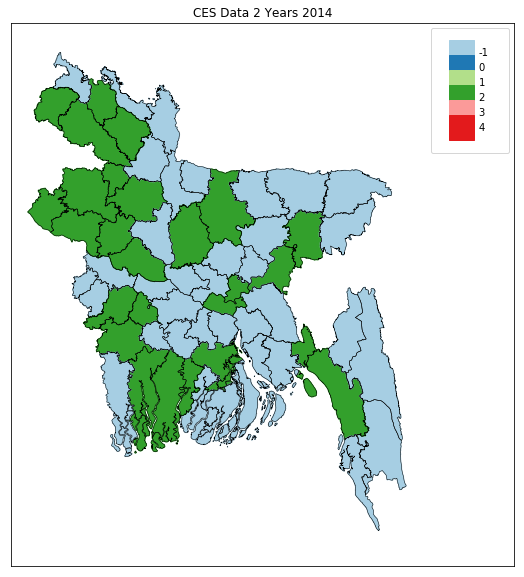

[2016]


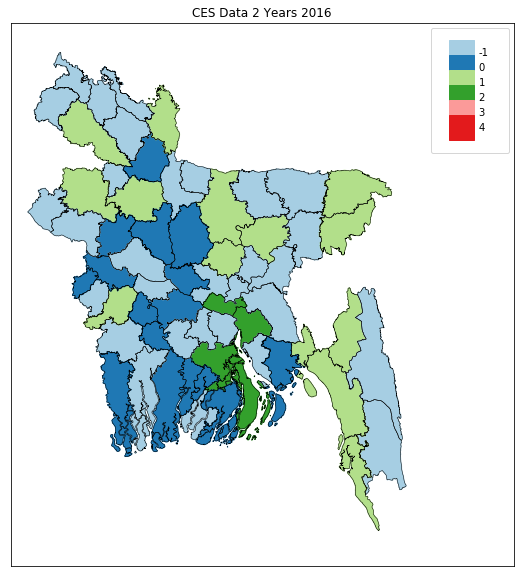

In [41]:
plot_clusters(input_df=datad_option1, shapefile=SHAPEFILE, geo_level=GEO_LEVEL, project=PROJECT, output=OUTPUT)